In [16]:
# Load the "autoreload" extension
%load_ext autoreload

%autoreload 2

import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import math
import cv2
from image import Image
from data import voc_data_helpers
from data.voc_data_helpers import extract_img_data
from det_util import DetTrainingManager
from shared_constants import RESIZE_MIN_SIZE, RESIZE_MAX_SIZE
from util import resized_dims, transform
%matplotlib inline




import keras
from keras import backend as K
from keras.layers import Input, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.models import Model, model_from_json
from keras.optimizers import SGD
import resnet
from resnet import resnet50_rpn, resnet50_classifier, resnet50_base, preprocess, pop_layer, resnet101_base, resnet50_rpn, resnet101_base, resnet101_rpn, resnet101_classifier
import vgg
from vgg import vgg16_rpn, vgg16_classifier, vgg16_base
from custom_layers import RoiResizeConv, StaticBatchNormalization, FixedBatchNormalization
from data import voc_data_helpers
from map_util import get_map
from loss_functions import cls_loss_rpn, bbreg_loss_rpn, cls_loss_det, bbreg_loss_det

NUM_CLASSES_VOC = 20
DEFAULT_NUM_ITERATIONS = 10
DEFAULT_LEARN_RATE = 1e-3
DEFAULT_MOMENTUM = 0.9
VOC_PATH = '/Users/ke/Downloads/VOCdevkit/VOC2007'

NUM_ROIS = 64

print(sys.version)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 12:43:10) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


[<image.GroundTruthBox obj_cls: bird, difficult: False, box: <image.Box x1: 115.2, y1: 112.0, x2: 422.40000000000003, y2: 505.6>>, <image.GroundTruthBox obj_cls: bird, difficult: False, box: <image.Box x1: 454.40000000000003, y1: 192.0, x2: 572.8000000000001, y2: 550.4>>]


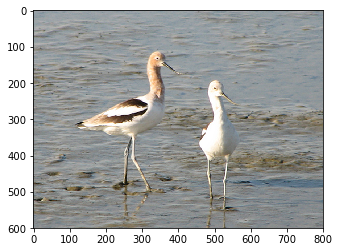

In [9]:
voc_path = '/Users/ke/Downloads/VOCdevkit/VOC2012'
class_mapping = voc_data_helpers.get_class_mapping()
#img, img_metadata = voc_data_helpers.extract_img_data(voc_path, '001915')
image = voc_data_helpers.extract_img_data(voc_path, '2008_002961')
image = image.horizontal_flip()
image, resized_ratio = image.resize_within_bounds(RESIZE_MIN_SIZE, RESIZE_MAX_SIZE)
new_width, new_height = resized_dims(image.width, image.height, 600)
rgb_data = cv2.cvtColor(image.data, cv2.COLOR_BGR2RGB)
batched_img = np.expand_dims(image.data, axis=0)
preprocessed = preprocess(image.data)
batched_preprocessed = np.expand_dims(preprocessed, axis=0)
print(image.gt_boxes)
plt.imshow(rgb_data)

In [41]:
# r50_rpn = resnet50_rpn(resnet50_base())
base_model = resnet50_base()
r50_rpn = resnet50_rpn(base_model, include_conv=True)

In [112]:
# r50_rpn.load_weights('../models/rpn_r50_20072012trainval.h5')
r50_rpn.load_weights('../models/rpn_weights_r50_step3_20072012trainval.h5')

In [ ]:
vgg_rpn = vgg16_rpn(vgg16_base(NUM_CLASSES_VOC + 1))

In [ ]:
vgg_rpn.load_weights('../models/rpn_weights_step3.h5')

In [30]:
r101_rpn = resnet101_rpn(resnet101_base())

In [ ]:
#r101_rpn.load_weights('../models/r101_rpn_single.h5')

In [114]:
manager = DetTrainingManager(model_rpn=r50_rpn, class_mapping=class_mapping, preprocess_func=preprocess)

In [115]:
rpn_input, rois_r50, y_class_num, y_transform = manager.get_training_input(image)

Executed function get_training_input in 2.2573142778128386 seconds
    Executed function get_det_samples in 0.00014276430010795593 seconds
    Executed function _process in 2.2552608102560043 seconds
        Executed function rois_to_truth in 0.005436111241579056 seconds
            Executed function one_hot_encode_bbreg in 0.0015460159629583359 seconds
            Executed function one_hot_encode_cls in 0.0001521371304988861 seconds
            Executed function cross_ious in 0.00011365674436092377 seconds
        Executed function nms in 0.16233959794044495 seconds
        Executed function get_valid_box_idxs in 9.815208613872528e-05 seconds
        Executed function _rois_from_image in 2.0807910095900297 seconds
            Executed function _get_rois in 0.0036126039922237396 seconds
                Executed function get_rois in 0.003603549674153328 seconds
                    Executed function sanitize_boxes_inplace in 0.00026582181453704834 seconds
                    Executed fun

In [ ]:
rois_r50

In [54]:
resnet_det = resnet50_classifier(NUM_ROIS, NUM_CLASSES_VOC + 1, resnet50_base())

In [ ]:
resnet_det.summary()

In [ ]:
rois_vgg, y_class_num, y_transform = det_y_true_batch_3(vgg_rpn, rgb_image, 64, class_mapping)

In [ ]:
rois_r101, y_class_num, y_transform = det_y_true_batch_3(r101_rpn, img2, 64, class_mapping)

In [ ]:
vgg_det = vgg16_classifier(NUM_ROIS, NUM_CLASSES_VOC + 1, vgg16_base(NUM_CLASSES_VOC + 1))

In [ ]:
vgg_det.load_weights("../models/det_weights_step2.h5")

In [ ]:
resnet_det = resnet50_classifier(NUM_ROIS, NUM_CLASSES_VOC + 1, resnet50_base())

In [ ]:
resnet_det.summary()

In [91]:
resnet_det.load_weights("../models/det_weights_r50_tmp.h5")
# resnet_det.load_weights("../models/det_weights_tmp.h5")

In [ ]:
def class_loss_internal(y_true, y_pred):
    # diff for bb reg
    x = y_true[:, :, 4*20:] - y_pred
    x_abs = K.abs(x)
    x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
    # only consider loss from the ground truth class
    # use smooth L1 loss function
    loss = K.sum(y_true[:, :, :4*20] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(1e-4 + y_true[:, :, :4*20])
    return 1 * loss


resnet_det2 = keras.models.load_model('../models/det_model_r50_tmp.h5',
                                      custom_objects={'RoiResizeConv': RoiResizeConv,
                                                      'StaticBatchNormalization': StaticBatchNormalization,
                                                      'FixedBatchNormalization': FixedBatchNormalization,
                                                      'cls_loss_det': cls_loss_det,
                                                     'bbreg_loss_det': bbreg_loss_det,
                                                     'class_loss_internal': class_loss_internal})

In [ ]:
cls_out_cls, cls_out_reg = vgg_det.predict_on_batch([batched_img, rois_r50])

In [ ]:
rois1 = np.array([[[18,10,22,27],[18,11,38,22],[20,18,22,11],[23,11,16,16],[23,15,16,16],[20,16,22,11],[25,14,16,16],[20,11,22,11],[17,14,22,11],[17,14,16,16],[19,11,16,16],[22,13,16,16],[20,13,22,11],[26,2,22,35],[3,15,45,22],[18,20,8,8],[19,0,32,21],[6,11,22,11],[21,12,11,5],[1,15,32,22],[22,20,5,11],[23,11,11,5],[11,16,22,11],[5,22,22,11],[23,15,5,11],[19,17,11,5],[16,0,32,26],[19,18,5,11],[17,21,8,8],[19,21,11,5],[25,0,31,24],[27,6,11,22],[6,7,32,30],[20,21,32,16],[26,7,16,16],[16,20,11,17],[31,0,22,25],[16,6,32,31],[19,13,11,5],[34,3,11,22],[23,7,16,16],[18,19,5,11],[29,5,27,22],[0,4,26,22],[31,23,8,8],[30,13,11,22],[16,14,11,22],[19,8,11,22],[28,13,5,11],[18,23,11,14],[18,14,11,5],[22,22,11,5],[9,5,22,11],[6,0,22,25],[28,10,8,8],[0,9,37,22],[23,9,22,28],[34,12,22,22],[13,17,16,16],[15,26,41,11],[32,0,24,31],[9,20,45,17],[33,4,22,33],[16,15,11,5]]])

In [74]:
cls_out_cls2, cls_out_reg2 = resnet_det.predict_on_batch([batched_preprocessed, rois_r50])
# cls_out_cls2, cls_out_reg2 = resnet_det.predict_on_batch([batched_img2, rois1])
# cls_out_cls2, cls_out_reg2 = resnet_det2.predict_on_batch([batched_img2, rois_r50])

In [75]:
out_cls = cls_out_cls2
out_reg = cls_out_reg2

cls_num = 2
print(out_cls[0,0:64,cls_num])
print(out_cls[0,0:64,20])
idx = 0
print(rois_r50[0,idx])
print(rois_r50[0,idx] * 16)
print(out_reg[0,idx,4*cls_num:4*(cls_num+1)])

bbreg = out_reg[0,idx,4*cls_num:4*(cls_num+1)] / np.array([10, 10, 5, 5])
print(bbreg)
print(transform(rois_r50[0,idx] * 16, bbreg))
new_coords = [transform(rois_r50[0,idx], bbreg)]

# from keras.optimizers import Adam
# optimizer = SGD(lr=1e-4)
# resnet_det2.compile(optimizer=optimizer, loss=[cls_loss_det, bbreg_loss_det(NUM_CLASSES_VOC)])
# res = resnet_det2.evaluate(x=[batched_preprocessed, rois_r50],y=[y_class_num, y_transform],batch_size=32)
# print(res)
# print("HELLO")

[  9.99948144e-01   9.99989510e-01   9.99966502e-01   9.99998212e-01
   9.99970555e-01   9.99969125e-01   9.99999762e-01   9.99992013e-01
   9.99987602e-01   9.99997735e-01   9.99951005e-01   9.99999762e-01
   9.99992013e-01   9.99999881e-01   9.99968171e-01   9.99987602e-01
   6.14949435e-19   2.12617334e-34   0.00000000e+00   1.14209393e-20
   1.37361546e-14   7.19097067e-26   2.53808389e-12   1.93162639e-32
   1.02348838e-14   4.03118848e-24   1.52412452e-13   2.28815204e-13
   1.24314540e-13   3.01746673e-19   6.19440286e-08   0.00000000e+00
   2.80571862e-27   1.26640692e-14   0.00000000e+00   0.00000000e+00
   9.65589332e-19   0.00000000e+00   2.58549931e-19   2.10420482e-24
   1.18166964e-13   6.96355294e-21   1.49665112e-35   2.84242082e-35
   1.29394143e-25   1.09884109e-25   1.67367203e-27   2.22701744e-22
   1.58848146e-18   7.75810874e-11   1.94836520e-18   2.09218030e-19
   2.86029631e-32   0.00000000e+00   0.00000000e+00   0.00000000e+00
   5.64694095e-29   1.21627442e-24

In [45]:
import tensorflow as tf
tout = cls_loss_det(tf.convert_to_tensor(y_class_num.astype('float32')), tf.convert_to_tensor(cls_out_cls2))
print(tf.Session().run(tout))

0.0656894


[28 10 39 32]
[(27.99990763166948, 11.999851559088739, 35.999370079245132, 34.001510478569955)]


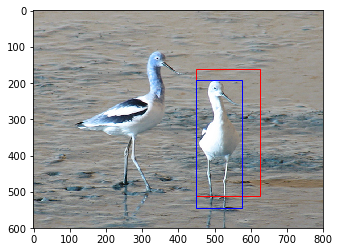

In [76]:
import time
fig,ax = plt.subplots(1)
ax.imshow(batched_img[0])
print(rois_r50[0,idx])
for x1,y1,x2,y2 in rois_r50[0,idx:idx+1]:
# for x1,y1,w,h in rois_r50[0,0:32]:
    x = x1 * 16
    y = y1 * 16
    w = (x2 - x1) * 16
    h = (y2 - y1) * 16
    rect = patches.Rectangle((x, y), w, h, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
print(new_coords)
for x1,y1,x2,y2 in new_coords:
    x = x1 * 16
    y = y1 * 16
    w = (x2 - x1) * 16
    h = (y2 - y1) * 16
    rect = patches.Rectangle((x, y), w, h, linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

In [ ]:
new_base = resnet.resnet101_base('../models/resnet101_base_weights_tf.h5')

In [77]:
y_class_num

array([[[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]]], dtype=int32)

In [ ]:
new_base.summary()

In [ ]:
resnet101_rpn = resnet50_rpn(new_base)

In [ ]:
resnet101_rpn.summary()

In [ ]:
new_base.layers[38].get_weights()

In [ ]:
new_base.load_weights('../models/resnet101_base_weights_tf.h5')

In [ ]:
new_base.summary()

In [ ]:
new_base.layers[38].get_weights()

In [ ]:
new_cls = resnet50_classifier(64, 21, new_base)

In [ ]:
new_cls.summary()

In [78]:
ref_base = resnet50_base()

In [79]:
class_mapping

{'aeroplane': 0,
 'bg': 20,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'diningtable': 10,
 'dog': 11,
 'horse': 12,
 'motorbike': 13,
 'person': 14,
 'pottedplant': 15,
 'sheep': 16,
 'sofa': 17,
 'train': 18,
 'tvmonitor': 19}

In [81]:
y_class_num[0, :, 2]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
from keras.applications import resnet50
a = resnet50.ResNet50()

In [ ]:
[layer.name for layer in a.layers]

In [ ]:
b = a.get_layer('bn5a_branch2c')

In [92]:
a.get_layer('res2a_branch2b').get_weights()

NameError: name 'a' is not defined

In [ ]:
[layer.name for layer in a.layers if isinstance(layer, BatchNormalization)]

In [ ]:
c = BatchNormalization(input_shape=(4,256))

In [ ]:
c.set_weights(weights=b.get_weights())

In [83]:
d = resnet50_classifier(64, 21, resnet50_base())

In [100]:
e = d.get_layer('bn3a_branch2a')

In [ ]:
e.set_weights(b.get_weights())

In [101]:
e.get_weights()

[array([ 0.65671211,  1.15259337,  1.31268799,  1.28000879,  1.31011748,
         1.14386034,  0.6745857 ,  1.52342904,  1.15534699,  0.86976641,
         1.16184485,  1.32720673,  1.19663489,  0.86922348,  1.38692772,
         0.74293178,  1.08678281,  1.20884049,  1.06516111,  1.27916908,
         1.48182487,  1.17433846,  0.92576319,  0.81313467,  1.33842719,
         1.08718181,  0.640378  ,  1.26880693,  0.86074769,  1.15411723,
         1.25686848,  1.08715725,  1.22036827,  0.7682929 ,  0.90226829,
         0.96529567,  1.23458362,  0.69614059,  0.83461267,  0.93570042,
         0.91524452,  1.0393095 ,  1.32533276,  0.77709609,  0.88827974,
         1.03250754,  1.22319651,  0.91544855,  1.32878685,  1.350353  ,
         0.66638887,  0.91669869,  0.63352001,  0.87747377,  0.85468912,
         0.73097241,  1.29101443,  1.12887514,  0.87841588,  1.10678077,
         1.4600035 ,  0.92624074,  1.09411907,  0.91542959,  0.84798867,
         0.87784052,  1.01695669,  0.70243758,  1.3

In [ ]:
e.layer._per_input_updates

In [ ]:
[layer.layer.momentum for layer in d.layers if layer.name.startswith('bn5')]

In [ ]:
r50_rpn.get_layer('conv1').get_weights()

In [105]:
d.get_layer('bn_conv1').get_weights()
#d.get_layer('bn5a_branch2a').layer.get_weights()

[array([ 1.09133124,  1.11386132,  0.87221205,  1.37758529,  1.16711926,
         1.1966964 ,  0.91123503,  1.56568909,  2.55365062,  0.88135672,
         1.19536138,  0.86340654,  0.9432478 ,  2.48657155,  1.03686082,
         1.28439963,  1.45141542,  1.30083323,  1.0089829 ,  1.37588179,
         1.0634737 ,  1.10251617,  2.63440537,  1.07639551,  1.08262336,
         1.41038513,  1.982566  ,  0.74499798,  0.93063259,  2.08454728,
         1.41469419,  0.87998098,  0.87213367,  0.51264292,  1.2891649 ,
         0.90243804,  0.88054538,  1.86448205,  1.38097703,  1.01025999,
         1.39416063,  1.04088795,  1.29404068,  0.52838659,  0.96318358,
         2.66858673,  1.16839743,  1.1092062 ,  0.83213937,  1.00367367,
         1.46831393,  1.5917623 ,  0.55286855,  1.25418806,  1.55602407,
         1.06906104,  0.85086322,  0.92903084,  1.41131306,  0.94525641,
         0.8614338 ,  0.91610289,  1.04259181,  1.01350999], dtype=float32),
 array([ 1.47949708, -1.1218344 , -1.064731  , 

In [104]:
resnet_det.get_layer('bn_conv1').get_weights()

[array([ 1.09133124,  1.11386132,  0.87221205,  1.37758529,  1.16711926,
         1.1966964 ,  0.91123503,  1.56568909,  2.55365062,  0.88135672,
         1.19536138,  0.86340654,  0.9432478 ,  2.48657155,  1.03686082,
         1.28439963,  1.45141542,  1.30083323,  1.0089829 ,  1.37588179,
         1.0634737 ,  1.10251617,  2.63440537,  1.07639551,  1.08262336,
         1.41038513,  1.982566  ,  0.74499798,  0.93063259,  2.08454728,
         1.41469419,  0.87998098,  0.87213367,  0.51264292,  1.2891649 ,
         0.90243804,  0.88054538,  1.86448205,  1.38097703,  1.01025999,
         1.39416063,  1.04088795,  1.29404068,  0.52838659,  0.96318358,
         2.66858673,  1.16839743,  1.1092062 ,  0.83213937,  1.00367367,
         1.46831393,  1.5917623 ,  0.55286855,  1.25418806,  1.55602407,
         1.06906104,  0.85086322,  0.92903084,  1.41131306,  0.94525641,
         0.8614338 ,  0.91610289,  1.04259181,  1.01350999], dtype=float32),
 array([ 1.47949708, -1.1218344 , -1.064731  , 

In [ ]:
resnet_det.metrics_names

In [103]:
resnet_det.get_layer('bn3a_branch2a').get_weights()

[array([ 0.65671211,  1.15259337,  1.31268799,  1.28000879,  1.31011748,
         1.14386034,  0.6745857 ,  1.52342904,  1.15534699,  0.86976641,
         1.16184485,  1.32720673,  1.19663489,  0.86922348,  1.38692772,
         0.74293178,  1.08678281,  1.20884049,  1.06516111,  1.27916908,
         1.48182487,  1.17433846,  0.92576319,  0.81313467,  1.33842719,
         1.08718181,  0.640378  ,  1.26880693,  0.86074769,  1.15411723,
         1.25686848,  1.08715725,  1.22036827,  0.7682929 ,  0.90226829,
         0.96529567,  1.23458362,  0.69614059,  0.83461267,  0.93570042,
         0.91524452,  1.0393095 ,  1.32533276,  0.77709609,  0.88827974,
         1.03250754,  1.22319651,  0.91544855,  1.32878685,  1.350353  ,
         0.66638887,  0.91669869,  0.63352001,  0.87747377,  0.85468912,
         0.73097241,  1.29101443,  1.12887514,  0.87841588,  1.10678077,
         1.4600035 ,  0.92624074,  1.09411907,  0.91542959,  0.84798867,
         0.87784052,  1.01695669,  0.70243758,  1.3

In [ ]:
d.get_layer('bn5a_branch2a').layer.trainable

In [ ]:
resnet_det2.summary()

In [ ]:
K.set_learning_phase(False)

In [ ]:
resnet50_base2(NUM_CLASSES_VOC+1)

In [32]:
r101_rpn.get_layer('bn_conv1').get_weights()

[array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32),
 array([ -3.82649869e-01,   6.76552504e-02,  -7.54784405e-01,
         -3.79394197e+00,  -3.66795599e-01,  -1.49371922e-01,
          3.48583245e+00,  -2.49202281e-01,   3.34703848e-02,
         -4.92252290e-01,   1.32800603e+00,   6.46880120e-02

In [106]:
r101_cls = resnet101_classifier(NUM_CLASSES_VOC+1, NUM_ROIS, resnet101_base())

In [137]:
r101_cls.get_layer('res5a_branch2a').get_weights()

[array([[[[-0.02280292,  0.02332561,  0.00456676, ..., -0.03463574,
           -0.00649201,  0.00717261],
          [-0.01011413,  0.00061489, -0.02196819, ...,  0.01161483,
            0.01394528,  0.01132941],
          [-0.01003715,  0.02239321, -0.00654926, ..., -0.01130832,
           -0.01798279,  0.00987203],
          ..., 
          [-0.00553416, -0.00883182, -0.01718671, ..., -0.00106783,
           -0.00114474, -0.03317692],
          [ 0.00244331, -0.002403  ,  0.00816836, ..., -0.01738538,
           -0.00752418,  0.00693093],
          [ 0.0131218 , -0.0109214 , -0.0054965 , ..., -0.03453198,
           -0.00110161,  0.05745678]]]], dtype=float32)]

In [92]:
r50_rpn.get_layer('bn5b_branch2b').get_weights()

ValueError: No such layer: bn5b_branch2b

In [61]:
r50_cls = resnet50_classifier(NUM_CLASSES_VOC+1, NUM_ROIS, resnet50_base())

In [83]:
r50_cls.get_layer('bn5b_branch2c').trainable

False